# Denoising Diffusion Probabilistic Models

<img src="Intro.gif"/>
<br>
<center> <span style="color:gray">[riffusion.com]</span>

* **In this tutorial, we will cover:**
* Preliminaries
    * Markovian processes
    * Example: one-dimensional random walk
    * Properties of Markovian processes
* DDPMs:
    * Forward and reverse diffusion
    * Loss function (ELBO strikes again)
    * Revisiting the noise reversal process
    * Training and sampling
    * Noise recovery model
    * Putting it all together...

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torchvision
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.Flowers102(root=".", download=True, transform=data_transform)

    return data

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(dataset=data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/home/mitchell/miniconda3/envs/deep_learn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preliminaries

* A **discrete time random process** is a sequence of random variables:
$$X_1,X_2,X_3,...,X_T,...$$ <br>

* We say that a discrete time random process satisfies the **Markovian property** if:
$$p(X_t|X_{t-1},X_{t-2},...,X_{1}) = p(X_t | X_{t-1})$$ <br>

* **Notable example**: one dimensional random walk:
<img src="random_walk.gif" width="350"/>
<br>
<center> <span style="color:gray">[Pierre Gombaud]</span>
    
$$ X_0 = 0 $$
And:
$$
X_{k+1} | X_k = \begin{cases}
    X_k+1 & \text{w.p } p \\
    X_k-1 & \text{w.p } 1-p
\end{cases}
$$

* **Properties of Markovian processes:**
    * Generalized Markovian property:
        * For every $i_1 < i_2 < ... < i_n < i_{n+1}$:
$$p(X_{i_{n+1}}|X_{i_n},X_{i_{n-1}}, ..., X_{i_1}) = p(X_{i_{n+1}}|X_{i_n})$$
    * Decomposition of the joint distribution:
$$ p(X^{(1...t)}) \triangleq p(X_1,...,X_t) = p(X_t | X_{t-1}) \cdot p(X_{t-1} | X_{t-2}) \cdot ... \cdot p(X_2|X_1) \cdot p(X_1)$$
    * Computing expectations and variances via total expectation and variance laws:
        * **Law of total expectation:** $\mathbb{E}[X_{k+1}] = \mathbb{E}_{X_k}[\mathbb{E}[X_{k+1}|X_k]]$
            + In the random walk example: $\mathbb{E}[X_{k+1}] = \mathbb{E}_{X_k}[p\cdot(X_k+1)+(1-p)\cdot(X_k-1)] = \mathbb{E}[X_k] + 2p-1$
            + And hence $\mathbb{E}[X_t] = t\cdot(2p-1)$
        * **Law of total Variance:** $Var(X_{k+1}) = \mathbb{E}_{X_k}[Var(X_{k+1}|X_k)] + Var_{X_k}(\mathbb{E}[X_{k+1}|X_k]) $
        + Exercise: compute the variance of each timestep in the random walk example.

## Denoising Diffusion Probabilistic Models (DDPMs)

* Diffusion Models are physics inspired models that were first introduced by [Sohl-Dickstein et. al](https://arxiv.org/abs/1503.03585) back in 2015.
* However, they got broadly popularized by [Ho et. al](https://arxiv.org/abs/2006.11239) in 2020 which showed that DDPMs can outperform state-of-the-art GANs.

### The forward and the reverse process

* Idea: Maintain multiple latent variables $x_1,...,x_T$.
    * incrementally add noise to the instance $x_0 \sim q(x_0)$ over $T$ steps in a **forward process** $q(x_t|x_{t-1})$
    * Learn to recover the image in a **reverse process** $p_\theta(x_{t-1}|x_t)$ where the prior is $p_\theta(x_T) \sim \mathcal{N}(\mathbf{0},\mathbf{I})$

<br>
<img src="forward_reverse.png"/>
<br>
<center> <span style="color:gray">[Ho et al.]</span>

* **The forward process**:
    * Unlike, VAEs this is a **non-learnable** markovian process in which the noise is gardually added.
    * The distribution of the data is: $x_0 \sim q(x_0)$.
    * Noise is added as follows: $q(x_t|x_{t-1}) := \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t-1}, \beta_t \mathbf{I})$.
    * $\beta_t > 0$ is a scalar hyperparameter refered to as the **variance schedule**.

In [2]:
def variance_schedule(start, timesteps, stop=None, scheduling_strategy='constant'):
    if scheduling_strategy == 'constant':
        betas = torch.ones(timesteps) * start
    elif scheduling_strategy == 'linear':
        betas = torch.linspace(start, stop, timesteps)
    else:
        raise NotImplementedError
    return betas.to(device)

T = 300
betas = variance_schedule(start=1e-4, timesteps=T, stop=2e-2, scheduling_strategy='linear')

* A very important property of the forward process is that $q(x_t|x_0)$ can be computed directly:
$$ q(x_t|x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha_t}}x_0, (1-\bar{\alpha_t})\mathbf{I})$$
* where $\alpha_t := 1- \beta_t$ and $\bar{\alpha_t} = \prod_{t=1}^T \alpha_t$.
    + Exercise: prove this.

In [3]:
import torch.nn.functional as F

# Pre-calculate different terms for closed form
alphas = (1. - betas).to(device)
cum_alphas = torch.cumprod(alphas, dim=0).to(device)
cum_alphas_prev = F.pad(cum_alphas[:-1], (1, 0), value=1.0).to(device)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas).to(device)
sqrt_cum_alphas = torch.sqrt(cum_alphas).to(device)
sqrt_one_minus_cum_alphas = torch.sqrt(1. - cum_alphas).to(device)
posterior_variance = (betas * (1. - cum_alphas_prev) / (1. - cum_alphas)).to(device)


def extract(v, t, x_shape):
    """
    Extract some coefficients at specified timesteps, then reshape to
    [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    out = torch.gather(v, index=t, dim=0).float()
    return out.view([t.shape[0]] + [1] * (len(x_shape) - 1))

* With these we can implement the direct sampling of $x_t$ given $x_0$ and $t$:

In [4]:
def direct_sampling(x_0, t):
    eps = torch.randn_like(x_0).to(device)
    sqrt_cum_alphas_t = extract(sqrt_cum_alphas, t, x_0.shape)
    sqrt_one_minus_cum_alphas_t = extract(sqrt_one_minus_cum_alphas, t, x_0.shape)
    x_t = sqrt_cum_alphas_t * x_0 + sqrt_one_minus_cum_alphas_t * eps
    return x_t, eps

* Let's simulate the forward diffusion process!

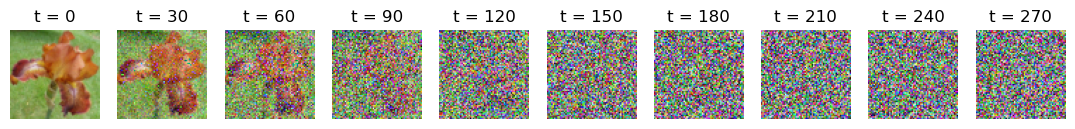

In [5]:
# Simulate forward diffusion
x_0 = next(iter(dataloader))[0]
x_0 = x_0[0].to(device) # Take the first image in the first batch
plt.figure(figsize=(15,15))

num_images = 10
stepsize = int(T/num_images)
for idx in range(0, T, stepsize):
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    plt.gca().title.set_text(f't = {idx}')
    plt.gca().axis('off')
    t = torch.Tensor([idx]).type(torch.long).to(device)
    img, _ = direct_sampling(x_0, t)
    img = img.to(device)
    show_tensor_image(img.cpu())

* Notice how the SNR will decrease over time.

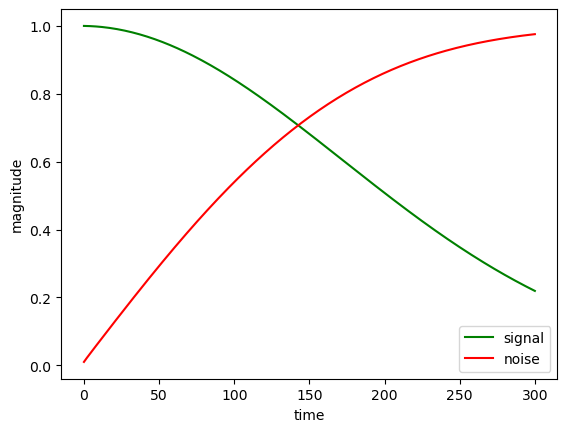

In [6]:
time = torch.linspace(start=0, end=T, steps=T)
signal = sqrt_cum_alphas.clone().cpu()
noise = sqrt_one_minus_cum_alphas.clone().cpu()
snr = signal / noise

plt.plot(time, signal, c='g', label='signal')
plt.plot(time, noise, c='r', label='noise')
plt.xlabel('time')
plt.ylabel('magnitude')
plt.legend()

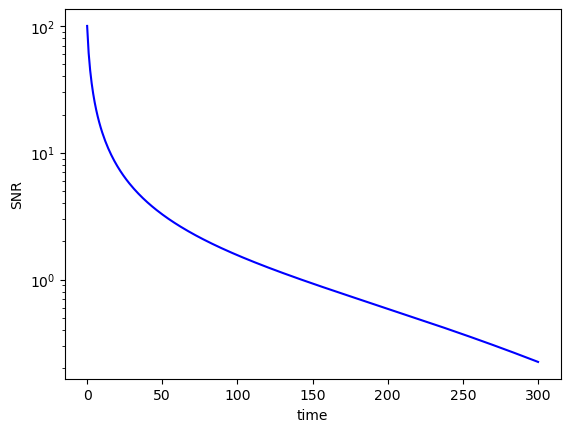

In [7]:
plt.xlabel('time')
plt.ylabel('SNR')
plt.plot(time, snr, c='b', label='snr')
plt.yscale('log')

* **The reverse process**:
    * Similiarly to VAEs, this is a **learnable** markovian process in which the noise is gardually removed.
    * The distribution of the final latent variable is standard normal: $x_T \sim p_\theta(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$.
    * Noise is removed as follows: $p_\theta(x_{t-1}|x_t) := \mathcal{N}(x_{t-1};\mathbf{\mu_\theta}(x_t,t), \mathbf{\Sigma_\theta}(x_t,t))$.
    * We will revisit the noise removal mechanism design later in this tutorial...

### ELBO loss strikes again

To optimize diffusion models we would maximize the log-likelihood $\log p_\theta(x_0)$ by maximizing the ELBO loss, similiarly to VAEs:

$$ \log p_\theta(x_0) =
\mathbb{E}_q[\log(\frac{q(x_{1:T}|x_0)}{p_\theta(x_{1:T}|x_0)} \cdot \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)})] =
D_{KL}(q(x_{1:T}|x_0) || p_\theta(x_{1:T}|x_0)) + \mathbb{E}_q[\log \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)}]$$

<br>
And so the ELBO is:
$$ \mathcal{L}(\theta;x_0) =
\mathbb{E}_q[\log \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)}] =
\mathbb{E}_q[\log p(x_T) + \sum_{t \geq 1} \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})}]$$
Which can be written also as:
$$ \mathcal{L}(\theta;x_0) = -D_{KL}(q(x_T|x_0) || p_\theta(x_T)) - \sum_{t>1} \mathbb{E}_q[D_{KL}(q(x_{t-1}|x_t,x_0)||p_\theta(x_{t-1}] + \mathbb{E}_q [\log p_\theta(x_0|x_1)]$$

Interpreting the terms in the ELBO:
* The first term $L_T$ is analogous to the latent space regularization in VAEs, however in our setting it is **constant** (why?).
* The terms in the sum $L_{t-1}$ can be interpreted as an **intermediate latent spaces disagreement errors**.
* The last term can be interpreted as the **reconstruction error**.

An important thing to notice about the $L_{t-1}$ is that they are tractable since the forward process posteriors are considtioned also on $x_0$:

$$ q(x_{t-1}|x_t,x_0) = \mathcal{N}(x_{t-1}; \tilde{\mu}(x_t,x_0),\tilde{\beta_t}\mathbf{I})$$

where:

$$ \tilde{\mu}(x_t,x_0) := \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0 + \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t$$

and:
$$\tilde{\beta}_t := \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \beta_t$$

<br>
<img src="elbo.jpeg"/>
<br>
<center> <span style="color:gray">[Ayan Das]</span>

### Revisiting the noise reversal process

* Recall that we still need to model the mean and variance in each noise reversal step:
$$ p_\theta(x_{t-1}|x_t) := \mathcal{N}(x_{t-1};\mathbf{\mu_\theta}(x_t,t), \mathbf{\Sigma_\theta}(x_t,t)) $$
* The authors chose $\mathbf{\Sigma_\theta}(x_t,t)$ to be a **non-learnable** isotropic Gaussian $\sigma_t^2 \mathbf{I}$.
* Under this choice, the $L_{t-1}$ terms simplify to:
    * $L_{t-1} = \mathbb{E}_q[\frac{1}{2\sigma_t^2} \lVert \tilde{\mu}(x_t,x_0)-\mu(x_t,t) \rVert ^2] + C$
* Since $x_t$ can be reparametrized as $x_t = \sqrt{\bar{\alpha_t}}x_0 + (1-\bar{\alpha_t})\mathbf{\epsilon}$ where $\mathbf{\epsilon} \sim \mathcal{N}(0,\mathbf{I})$ and by opening up the definition of $\tilde{\mu}(x_t,x_0)$ we get:
$$ L_{t-1} - C = \mathbb{E}_{x_0,\epsilon}[\frac{1}{2\sigma^2_t} \lVert \frac{1}{\sqrt{\alpha_t}}(x_t(x_0,\epsilon)-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon)-\mu_\theta(x_t(x_0,\epsilon),t)\rVert^2]$$
* In order to minimize this, $\mu_\theta(x_t,t)$ should predict:
$$ \mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}(x_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon)$$
* Since $x_t$ is given to the model, it's a natural choice to choose the following parametrization:
$$ \mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}(x_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t,t))$$

In [8]:
def mu(pred_eps, x_t, t):
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x_t.shape)
    betas_t = extract(betas, t, x_t.shape)
    sqrt_one_minus_cum_alphas_t = extract(sqrt_one_minus_cum_alphas, t, x_t.shape)
    mu = sqrt_recip_alphas_t * (x_t - betas_t * pred_eps / sqrt_one_minus_cum_alphas_t)
    return mu

* And the objective is further simplified:
$$ L_{t-1}-C = \mathbb{E}_{x_0,\epsilon}[\frac{\beta_t^2}{2\sigma_t^2\alpha_t(1-\bar{\alpha}_t)} \lVert \epsilon - \epsilon_\theta(\sqrt{\bar{\alpha_t}}x_0 + (1-\bar{\alpha_t})\epsilon, t) \rVert^2 ]$$
* The final objective is an unweighted version of the above:
$$ L_{simple}(\theta) = \mathbb{E}_{x_0,\epsilon}[\lVert \epsilon - \epsilon_\theta(\sqrt{\bar{\alpha_t}}x_0 + (1-\bar{\alpha_t})\epsilon, t) \rVert^2 ]$$
    + Can be interpreted as the **noise recovery** in the $t$-th step.
* Yields to a very simple **Training** and **Sampling** procedures:

<br>
<img src="training_and_sampling.png"/>
<br>
<center> <span style="color:gray">[Ho et. al]</span>


* Let us implement the loss function:

In [9]:
import torch.nn as nn
loss_fn = nn.L1Loss()

def compute_loss(pred_eps_model, x_0, t):
    with torch.no_grad():
        x_t, true_eps = direct_sampling(x_0, t)
    noise_pred = pred_eps_model(x_t, t)
    return loss_fn(true_eps, noise_pred)

* And the sampling procedure:

In [10]:
@torch.no_grad()
def sample_timestep(pred_eps_model, x_t, t):
    # A single noise reversal iteration
    pred_eps = pred_eps_model(x_t, t)
    posterior_variance_t = extract(posterior_variance, t, x_t.shape)
    z = 0 if t==0 else torch.sqrt(posterior_variance_t) * torch.randn_like(x_t)
    return mu(pred_eps, x_t, t) + z

@torch.no_grad()
def sample_plot_image(pred_eps_model):
    # Sample a single image and visualize the reconstruction
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    plt.figure(figsize=(15,15))
    num_images = 10
    stepsize = int(T/num_images)

    for i in reversed(range(0,T)):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(pred_eps_model, img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            plt.gca().title.set_text(f't = {i}')
            plt.gca().axis('off')
            show_tensor_image(img.detach().cpu().squeeze())
    plt.show()

### Noise recovery model

* A U-Net like PixelCNN++ backbone:

<br>
<img src="PixelCNN++.ppm"/>
<br>
<center> <span style="color:gray">[Ying Da Wang]</span>

* Diffusion time $t$ is specified by adding the Transformer sinusoidal position embedding
into each residual block.

In [11]:
import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

* We will implement a simplified version of it here:

In [12]:
from torch import nn

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

### Training the model

Epoch 0 |  Loss: 0.6859 


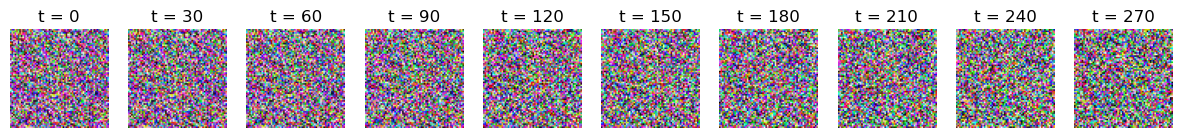

Epoch 5 |  Loss: 0.2968 


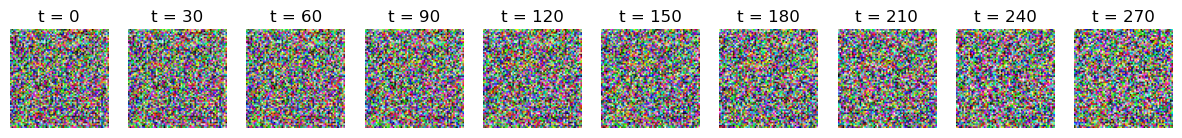

Epoch 10 |  Loss: 0.2780 


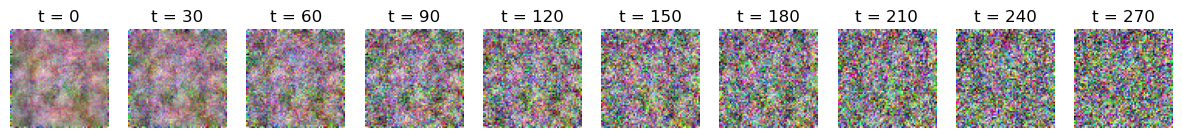

Epoch 15 |  Loss: 0.2484 


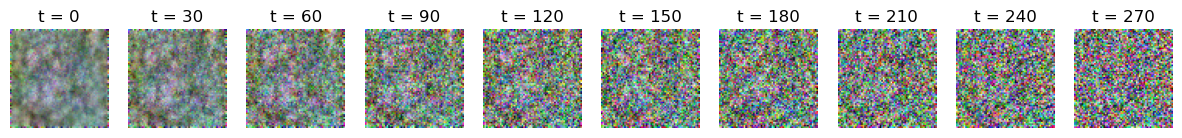

Epoch 20 |  Loss: 0.2348 


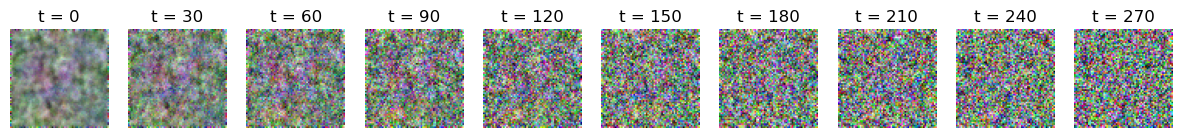

Epoch 25 |  Loss: 0.2274 


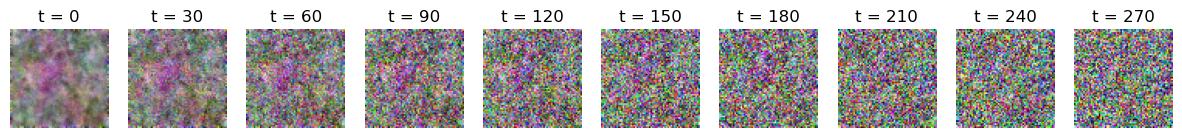

Epoch 30 |  Loss: 0.2203 


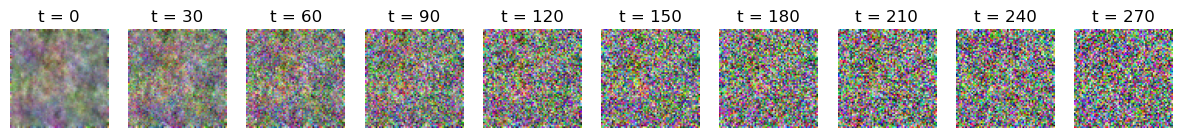

Epoch 35 |  Loss: 0.2406 


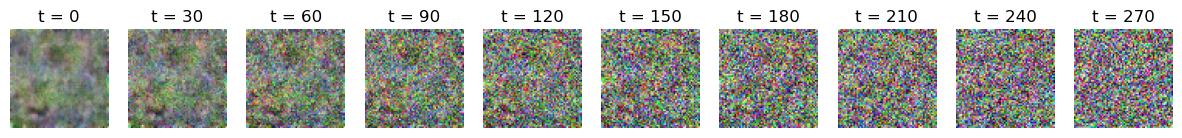

Epoch 40 |  Loss: 0.2061 


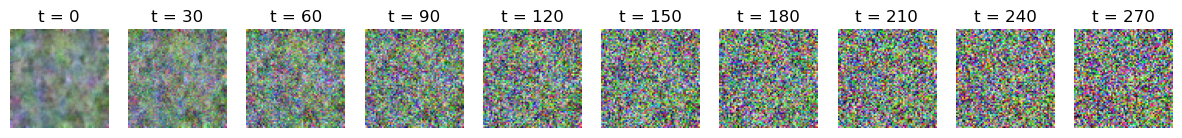

Epoch 45 |  Loss: 0.2001 


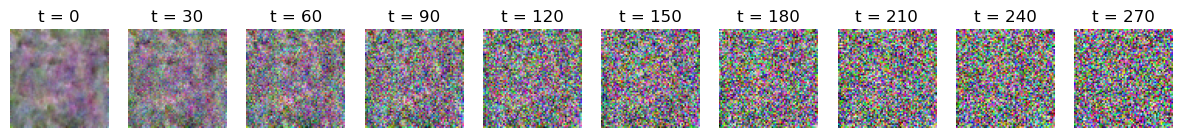

Epoch 50 |  Loss: 0.2014 


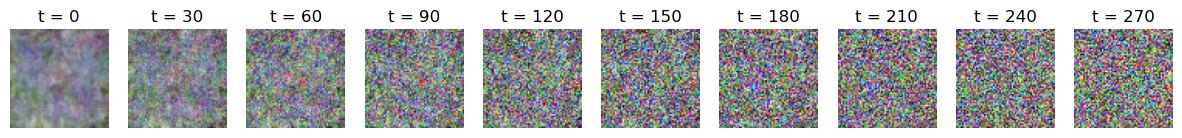

Epoch 55 |  Loss: 0.1873 


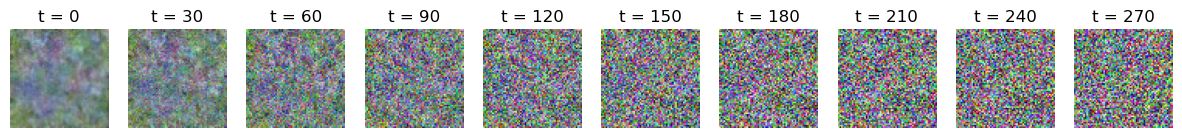

Epoch 60 |  Loss: 0.1866 


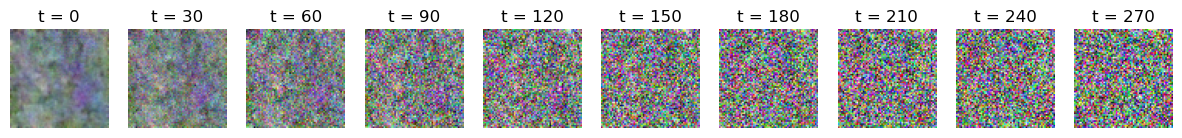

Epoch 65 |  Loss: 0.1897 


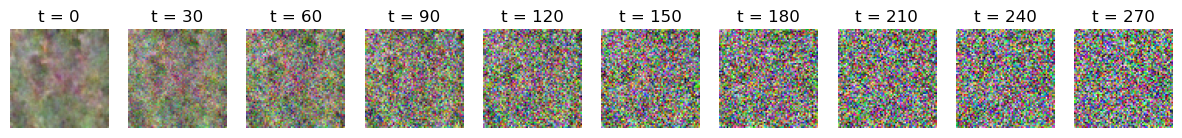

Epoch 70 |  Loss: 0.1859 


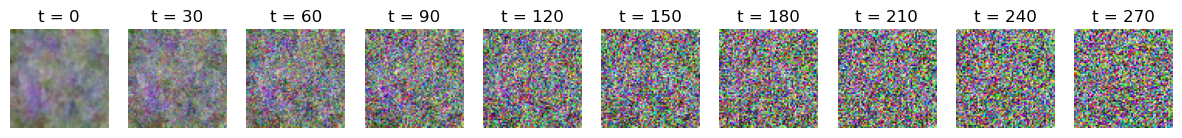

Epoch 75 |  Loss: 0.1847 


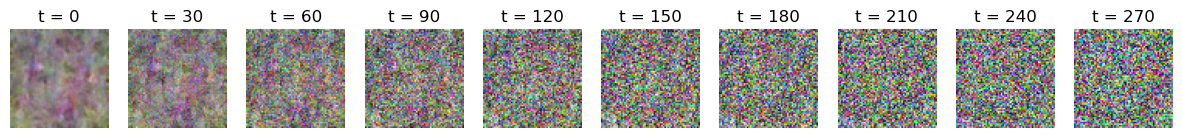

Epoch 80 |  Loss: 0.1857 


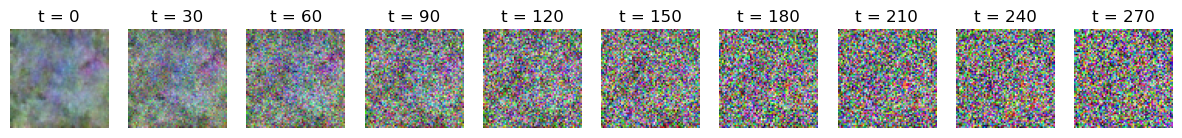

Epoch 85 |  Loss: 0.1766 


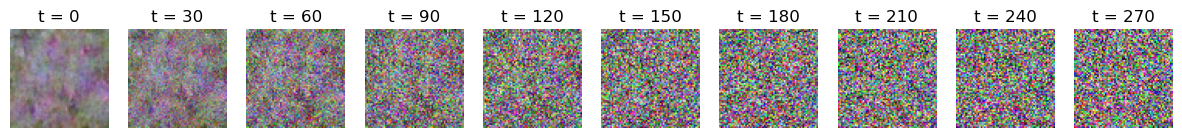

Epoch 90 |  Loss: 0.1818 


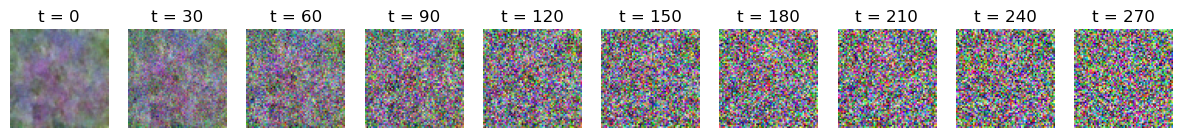

Epoch 95 |  Loss: 0.1854 


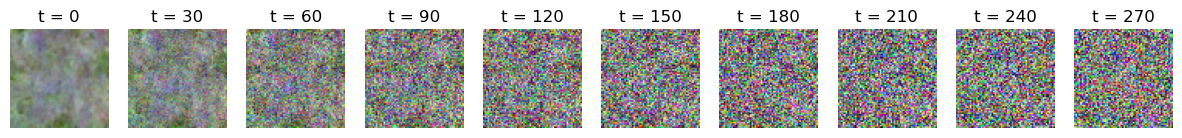

In [13]:
from torch.optim import Adam
pred_eps_model = SimpleUnet()
pred_eps_model.to(device)
optimizer = Adam(pred_eps_model.parameters(), lr=0.001)
num_epochs = 100 # Try more!

for epoch in range(num_epochs):
  avg_loss = 0
  n_batches = 0
  
  for step, batch in enumerate(dataloader):

    imgs, _ = batch
    imgs = imgs.to(device)
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long().to(device)

    optimizer.zero_grad()
    loss = compute_loss(pred_eps_model, imgs, t)
    loss.backward()
    optimizer.step()

    avg_loss += loss.item()
    n_batches +=1
  
  avg_loss /= n_batches
  if epoch % 5 == 0:
    pred_eps_model.eval()
    print(f"Epoch {epoch} |  Loss: {avg_loss:.4f} ")
    sample_plot_image(pred_eps_model)
    pred_eps_model.train()

## Credits
* This tutorial was written by Mitchell Keren Taraday.
* Some of the code parts were adapted from: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL#scrollTo=KOYPSxPf_LL7